## 1. The Hypothesis

In past years we have seen a lot of cross-domain applications from various deep learning areas to particular real-life cases with apparently little connection. One of those areas is that of applying deep representation learning based on neural language processing to business analytics systems and recommender systems in particular.
The intuition behind our proposed deep learning pipeline is that we could, at least in theory, generate, through multiple modeling iterations, powerful-enough semantic vector space embeddings for each individual item (product) so that we can infer replacements items and propose them in the case on original product shortages – all of these in a self-supervised setting
The hypothesis is that we can apply both direct retrofitting-based fine-tuning on the pre-trained product embeddings as well as re-construction of the GloVe vector space with new co-occurrence matrices in order to generate a product vector space model able to generate item-replacement information. More precisely the hypothesis is that our proposed approach will reduce the cosine distance between products that can actually replace each other in real life in a similar manner as presented in the work of Faruqui et al, Dingwall et al, that addresses word vectors, as well as push the distance of the product embeddings that are not similar but still have a semantic relationship resulted from the vector space optimization process.

## 2. The Data

For our experiment we decided to use a real-life transactional dataset that contains more than 2M transactions of a retailer with various locations over a period of more than 3 years. Although the dataset contains more than 15,000 different products in order to speed-up experiment time using full in-GPU training we reduced the number of products to a maximum of 13,000 top sold products.

_Further information on the data can be observed in the data loading, preparation and minimal visualization of the experiment._

#### We load the required packages

In [1]:
import numpy as np
from scipy import sparse
import itertools
import os
import pandas as pd
from datetime import datetime as dt
from time import time
import textwrap
from itertools import combinations
import matplotlib.pyplot as plt
%matplotlib inline

#### Setup global variables and pretty-prints

In [2]:
DEBUG = True # in-development flag

DATA_HOME = 'exp_data'
MODEL_HOME = 'exp_models'
DATA_FILE = os.path.join(DATA_HOME, 'df_tran_proc_top_13.5k.csv')
DATA_SLICE_FILE = os.path.join(DATA_HOME, 'df_tran_proc_top_13.5k_slice.csv')
META_FILE = os.path.join(DATA_HOME, 'df_items_top_13.5k.csv')
META_INFO = os.path.join(DATA_HOME, 'obfuscated_keys.txt')

MCO_OUT_FILE = os.path.join(MODEL_HOME, 'exp_mco.npz')


CHUNK_SIZE = 100 * 1024 ** 2 # read 100MB chunks

MAX_N_TOP_PRODUCTS = 13000  # top sold products

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision', 4)  
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=500)

plt.style.use('ggplot')


### 2.1. Data processing approach


Due to the size of transactional databases that often have billions of transactions each with many individual items we generate the proposed MCO with efficient batch reading of the transactional data. 

_For the purpose of efficiently processing the transactional records we have `generate_sparse_mco(file_name)` function with its `add_to_mco` helper method_

#### Utility functions

In [3]:
lst_log = []
_date = dt.now().strftime("%Y%m%d_%H%M")
log_fn = dt.now().strftime("logs/"+_date+"_log.txt")

def P(s=''):
    lst_log.append(s)
    print(s, flush=True)
    try:
        with open(log_fn, 'w') as f:
            for item in lst_log:
                f.write("{}\n".format(item))
    except:
        pass
    return

def Pr(s=''):
    print('\r' + str(s), end='', flush=True)

#### MCO generation


In [22]:

def add_to_mco(df_chunk, dct_mco, basket_id_field, item_id_field):
  Pr("  Grouping the transactions...")
  t1 = time()
  transactions = df_chunk.groupby(basket_id_field)[item_id_field].apply(list)
  nr_trans = df_chunk[basket_id_field].unique().shape[0]
  t_trans = time() - t1
  Pr("  Transacts:   {} (grouped in {:.2f} min)".format(
      nr_trans, t_trans / 60))
  P("")
  times = []
  counts = []
  time_delta = 1000
  last_time = time()
  for i, (index, l) in enumerate(transactions.items()):
    t1 = time()
    market_basket = np.unique(l)  # keep only unique elements
    counts.append(market_basket.shape[0])
    if market_basket.shape[0] == 1:
      continue
    perm_market_basket = list(itertools.permutations(market_basket, 2))
    for pair in perm_market_basket:
      if pair not in dct_mco: 
        dct_mco[pair] = 0
      dct_mco[pair] += 1
    if (i % time_delta) == 0:
      elapsed = time() - last_time
      last_time = time()
      times.append(elapsed)
      mean_time = np.mean(times) / time_delta
      remain_time = nr_trans * mean_time - (i + 1) * mean_time
      Pr("  Processed transactions {:.1f}% - {:.2f} min remaning...".format(
          (i + 1) / nr_trans * 100,
         remain_time / 60))
    # endfor
  # endfor
  P("")
  return dct_mco, counts


def show_distrib(data, cutoff=np.inf, plot=False, return_data=False):
  d = data.astype(int)
  d[d>cutoff] = cutoff
  _h = np.bincount(d).tolist()
  _x = np.arange(len(_h))
  s_counts = ["{:02d}".format(x) for x in _h][:15]
  s_nitems = ["{:>"+str(len(x))+"}" for x in s_counts]# ["{:02d}".format(x) for x in range(max(all_counts)+1)]
  s_nitems = [x.format(i) for i,x in enumerate(s_nitems)]
  P("    Counts:   " + ' '.join(s_counts))
  P("    Nr items: " + ' '.join(s_nitems))
  if plot:
    plt.figure(figsize=(10,6))
    plt.bar(x=_x, height=_h, log=True)
    plt.ylabel("Count")
    plt.xlabel("Values")
    plt.title("Distribution (logscale)")
    plt.show()  
  if return_data:
    return _x, _h
  else:
    return

_MAX_COOC_VAL = 250
_MCO_FILE  = os.path.join(DATA_HOME, 'mco_top_13.5k.npz')


def generate_sparse_mco(file_name, 
                        chunk_size=CHUNK_SIZE, 
                        basket_id_field='BasketId', 
                        item_id_field='IDE',
                        date_field='TimeStamp',
                        plot=False,
                        return_counts=False,
                        ):
  t1 = time()
  t2 = time()
  min_date = None
  max_date = None
  if DEBUG:
    P("Loading MCO...")
    csr_mco = sparse.load_npz(_MCO_FILE)
    P("Loading raw data...")
    df = pd.read_csv(DATA_FILE)
    all_counts = df.groupby(basket_id_field)['IDE'].count()
  else:      
    data_size = os.path.getsize(file_name)
    P("Reading transactional data file '{}' of size {:.2f} GB...".format(file_name, data_size / 1024**3))
    chunk_generator = pd.read_csv(file_name, chunksize=chunk_size)  
    all_counts = []
    dct_mco = {}
    n_rows = 0
    for i, df in enumerate(chunk_generator):
      if date_field in df.columns:
        _max_date = df[date_field].max()
        _min_date = df[date_field].min()
        if min_date is None or _min_date < min_date:
          min_date = _min_date
        if max_date is None or _max_date > max_date:
          max_date = _max_date
          
      n_rows += df.shape[0]
      P("Processing chunk {} of data:".format(i+1))
      P("  Start date:  {}".format(_min_date))
      P("  End date:    {}".format(_max_date))
      P("  Chunk/sofar: {}/{}".format(df.shape[0], n_rows))
      dct_mco, counts = add_to_mco(df, dct_mco,  basket_id_field, item_id_field)
      all_counts += counts
    # end for
    all_counts = np.array(all_counts)
    P("  Converting dict to sparse matrix...")
    t2 = time()
    csr_mco = sparse.csr_matrix((
            list(dct_mco.values()),
            [list(x) for x in zip(*list(dct_mco.keys()))],
        ))
  t3 = time()
  t_full = t3 - t1
  t_csr = t3 - t2
  P("  MCO Processing done in {:.2f} min (sparse mat creation: {:.2f} min):".format(
      t_full / 60, t_csr / 60))
  P("  Start date: {}".format(min_date))
  P("  End date:   {}".format(max_date))
  P("  Max co-occ: {}".format(csr_mco.max()))
  P("  Co-occurence distribution:")
  _xc, _hc = show_distrib(csr_mco.data, cutoff=_MAX_COOC_VAL, return_data=True)
  P("  Transactions size distrib:")
  _x, _h = show_distrib(all_counts, cutoff=25, return_data=True)
  P("  Transactional data:")
  P(textwrap.indent(str(df.iloc[:15]), " " * 4))
  P("  MCO data:")
  P(textwrap.indent(str(csr_mco[:15,:15].toarray()), " " * 4))
  if plot:
    plt.figure(figsize=(15,9))
    plt.bar(x=_x, height=_h, log=True)
    plt.ylabel("Number of transactions")
    plt.xlabel("Number of items per transaction")
    plt.title("Distribution of products per transaction (logscale)")
    plt.show()
    plt.figure(figsize=(15,9))
    plt.bar(_xc, _hc, log=True)
    plt.title("Distribution of co-occurence counts (logscale)")
    plt.ylabel("Number of co-occurences")
    plt.xlabel("Co-occurence count")    
    plt.show()
  sparse.save_npz(csr_mco, MCO_OUT_FILE)
  if return_counts:
    return csr_mco, _h
  else:
    return csr_mco
  

def load_categories(df_meta, mapping_file):
  import json
  with open(mapping_file, 'rb') as fh:
    dct_mapping = json.load(fh)
  for field in dct_mapping:
    dct_rev = {v:k for k,v in dct_mapping[field].items()}
    hn = df_meta[field].apply(lambda x: dct_rev[x])
    df_meta[field+'_name'] = hn
  return df_meta, dct_mapping
    

### 2.2 Understanding the data

The proposed experimental real-life data comes within a few files generated by SQL commands and exports from an existing ERP system of our retailer. The most notable data files are the transactional database file and the metadata file.  The metadata information taken directly from a real-life production system (ERP) contains raw information minimally describing each product-SKU `IdemId` with product name (`ItemName`) and other information such as number of item sales in observed in the selected period, a unique sequential item identificator (`IDE`) as well as as hierarchy information in two fields `Ierarhie1` and `Ierarhie2` that will be further used as a knowledge graph. There is also a secondary de-obfuscation data-source that contains for each hierarchy identified the actual name of that category. This information can also be used as a source for self-supervision in the process of creating the knowledge graph for the fine-tuning of our semantic vector space model.

The real-life transactional dataset, as previously mentioned, contains over 6M observations for over 2M different transactions. Each observation in the transactional database contains a `BasketId` identifier of the transaction as well as individual transaction detail information such as `ItemId` (and its counterpart `IDE`), a `SiteId` field that identifies the location of that particular transaction, a `TimeStamp` time-identification that is basically the same for all items of the same transaction, a quantity field, a customer identifier field and a product availability indicator.



_For the metadata we load the whole file and analyse its content while for the transactional database we take a quick look at the first chunk of 15 rows_

In [23]:
def show_product(IDE, df):
    rec = df[df.IDE==IDE].iloc[0]
    P("   Name:  {}".format(rec.ItemName))
    P("   Id:    {}".format(rec.ItemId))
    P("   Freq:  {}".format(rec.Freq))
    P("   Hrchy: {}/{}".format(rec.Ierarhie1, rec.Ierarhie2))
    return
    
P("Metatada information:")    
df_meta = pd.read_csv(META_FILE)
P("  Total no of products: {}".format(df_meta.ItemId.unique().shape[0]))
P("  Total no of level 1 hierarchies: {}".format(df_meta.Ierarhie1.unique().shape[0]))
P("  Total no of level 2 hierarchies: {}".format(df_meta.Ierarhie2.unique().shape[0]))
P("  Most sold individual product over period:")
show_product(df_meta[df_meta.Freq == df_meta.Freq.max()].iloc[0]['IDE'], df_meta)
P("  Least sold individual product over period:")
show_product(df_meta[df_meta.Freq == df_meta.Freq.min()].iloc[0]['IDE'], df_meta)
df_meta.iloc[:15]

Metatada information:
  Total no of products: 15000
  Total no of level 1 hierarchies: 24
  Total no of level 2 hierarchies: 188
  Most sold individual product over period:
   Name:  YUVAL NOAH HARARI / SAPIENS. SCURTA ISTORIE A OMENIRII
   Id:    545535
   Freq:  21248
   Hrchy: 1/17
  Least sold individual product over period:
   Name:  JONATHAN COE / CASA SOMNULUI (TOP10)
   Id:    459785
   Freq:  135
   Hrchy: 1/0


,ItemId,IDE,Freq,ItemName,Ierarhie1,Ierarhie2,IsActive
0,545535,0,21248,YUVAL NOAH HARARI / SAPIENS. SCURTA ISTORIE A OMENIRII,1,17,1
1,398648,1,16058,REZERVE STILOU T10 BLUE LAMY SET,11,134,1
2,406083,2,13371,FELICITARI A 7331335123458,11,107,1
3,576732,3,11656,YUVAL NOAH HARARI / HOMO DEUS. SCURTA ISTORIE A VIITORULUI,1,17,1
4,563633,4,10381,MARK MANSON / ARTA SUBTILA A NEPASARII,1,48,1
5,486656,5,8592,ECKHART TOLLE / PUTEREA PREZENTULUI. ED. VI,1,48,1
6,258901,6,8341,TURTA DULCE TIP INIMIOARE,20,269,1
7,602874,7,7955,YUVAL NOAH HARARI / 21 DE LECTII PENTRU SECOLUL XXI,1,17,1
8,163219,8,7921,CARTI POSTALE (2 S DESIGN) #2000032105856,11,23,1
9,259150,9,7904,JELLY BEAN 75G FT GOURMET BOX F0075-0696F,20,161,1


##### Now we can de-obfuscate the `Ierarhie1` and `Ierarhie2` fields

In [24]:
df_meta, dct_categories = load_categories(df_meta, META_INFO)
df_meta

,ItemId,IDE,Freq,ItemName,Ierarhie1,Ierarhie2,IsActive,Ierarhie1_name,Ierarhie2_name
0,545535,0,21248,YUVAL NOAH HARARI / SAPIENS. SCURTA ISTORIE A OMENIRII,1,17,1,CARTE ROM,ISTORIE
1,398648,1,16058,REZERVE STILOU T10 BLUE LAMY SET,11,134,1,PAPETARIE,Instrumente de scris
2,406083,2,13371,FELICITARI A 7331335123458,11,107,1,PAPETARIE,Giftware
3,576732,3,11656,YUVAL NOAH HARARI / HOMO DEUS. SCURTA ISTORIE A VIITORULUI,1,17,1,CARTE ROM,ISTORIE
4,563633,4,10381,MARK MANSON / ARTA SUBTILA A NEPASARII,1,48,1,CARTE ROM,DEZVOLTARE PERSONALA
...,...,...,...,...,...,...,...,...,...
14995,615497,14995,135,DARK 72% FAIRTRADE & ORGANIC 25G BAR,13,216,1,GASTRONOMIE AA,Choco Bars/Tablet BIO
14996,622485,14996,135,CARTE CU FERESTRUICI. ANIMALE. BEBE INVATA,1,3,1,CARTE ROM,CARTI PENTRU COPII
14997,631762,14997,135,INTO THE BLUE LANDSCAPE / GB173,5,42,1,PAPETARIE AA,Pungi de cadou
14998,632847,14998,135,OSHO. MEDITATII PENTRU OAMENII OCUPATI,1,49,1,CARTE ROM,SPIRITUALITATE / MEDITATIE


In [25]:
chunk_reader = pd.read_csv(DATA_SLICE_FILE, iterator=True) 
chunk_reader.get_chunk(15)

,BasketId,ItemId,SiteId,TimeStamp,Qtty,ClientId,IsActive,IDE
0,7130756,441093,26,2016-01-01 14:49:02.403,1.0,-103,1,1638
1,7130756,464012,26,2016-01-01 14:49:02.403,1.0,-103,1,1975
2,7130756,464013,26,2016-01-01 14:49:02.403,1.0,-103,1,2192
3,7130802,377742,20,2016-01-01 15:49:03.860,1.0,-103,1,2132
4,7130802,405083,20,2016-01-01 15:49:03.860,1.0,-103,1,213
5,7130802,405084,20,2016-01-01 15:49:03.860,1.0,-103,1,165
6,7130803,365473,26,2016-01-01 15:49:42.567,1.0,-103,1,354
7,7130803,381249,26,2016-01-01 15:49:42.567,1.0,-103,1,10603
8,7130809,344274,26,2016-01-01 15:53:19.953,1.0,-103,1,5416
9,7130809,393877,26,2016-01-01 15:53:19.953,1.0,-103,1,5693


In [26]:
chunk_reader.close()

### 2.3 NLU vs BPA
In terms of natural language models analogy to Business Predictive Analytics systems, we consider each individual basket as a “sentence” and consider each individual product id as a “word”. Referring to our proposed method of constructing matrix of co-occurrence counts and applying GloVe approach for the vector space representation modeling we have two options: 

 - using a specific context window size controlled as a model hyperparameter with or without weighting between focal and each individual item;
 - considering each transaction as the overall context with no distance weighting between the focal word and the context word;

Regarding the context window it is important to note that for online shopping systems the items ordering, in each individual transaction, is quite important as it is directly correlated to the user journey in the website. As such for the particular case the definition of a hyperparameter that will control the context window size is important. For classic brick-and-mortar retailers the order of each product in the receipt is not important as it is unlikely that it reflects the actual user sequence of actions.
In our particular case of the real-life dataset we have a retailer that has over 30 locations and a website that seems to generate less than 10% of the revenue. As a result we decided to consider each transaction as a single-context for the computing of item co-counts.

With regard to the meta-data that can generate important knowledge graph information for our self-supervised approach we found out that the _detail category_ or the so called "level 2 hierarchy" has a finer granularity than the first level.

_Now the next logical step is to generate the matrix of item co-occurrence counts_

Loading MCO...
Loading raw data...
  MCO Processing done in 0.09 min (sparse mat creation: 0.09 min):
  Start date: None
  End date:   None
  Max co-occ: 5998.0
  Co-occurence distribution:
    Counts:   00 7005638 964478 305856 143694 80710 51496 35258 25778 19350 14322 11800 10006 8060 6630
    Nr items:  0       1      2      3      4     5     6     7     8     9    10    11    12   13   14
  Transactions size distrib:
    Counts:   00 00 1243003 504372 204938 91906 44980 22726 12586 7060 4208 2502 1613 1063 726
    Nr items:  0  1       2      3      4     5     6     7     8    9   10   11   12   13  14
  Transactional data:
        BasketId  ItemId  SiteId                TimeStamp  Qtty  ClientId  IsActive    IDE
    0    7130756  441093      26  2016-01-01 14:49:02.403   1.0      -103         1   1638
    1    7130756  464012      26  2016-01-01 14:49:02.403   1.0      -103         1   1975
    2    7130756  464013      26  2016-01-01 14:49:02.403   1.0      -103         1   21

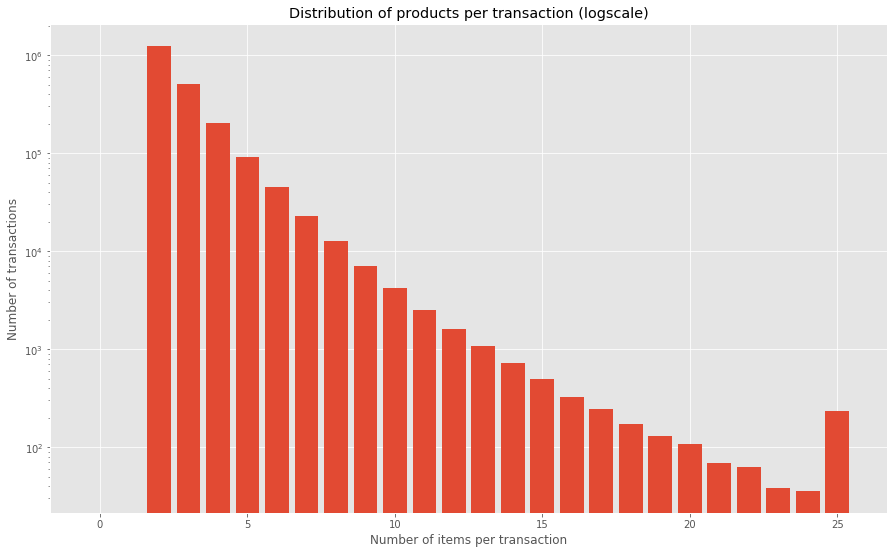

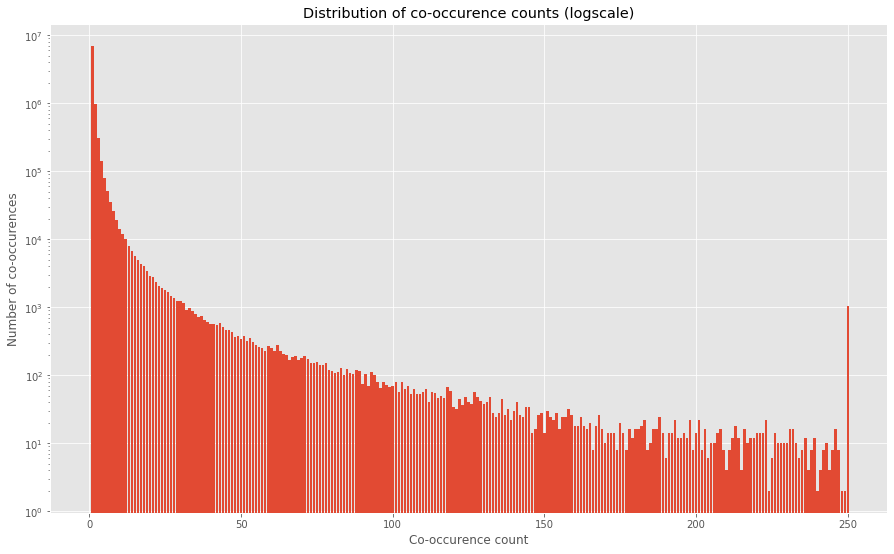

In [27]:
csr_mco, tran_sizes = generate_sparse_mco(DATA_FILE, plot=True, return_counts=True)

In [29]:
# we slice and convert the sparse matrix
np_mco = csr_mco.toarray()[:MAX_N_TOP_PRODUCTS,:MAX_N_TOP_PRODUCTS]
df_meta = df_meta.iloc[:MAX_N_TOP_PRODUCTS]
# raw sanity-check
for i in range(np_mco.shape[0]):
    assert i in df_meta.IDE

import pprint
pprint.pprint(dct_categories)

{'Ierarhie1': {'ACCESORII GASTRO': 28,
               'ACCESORII GASTRO AA': 9,
               'ALTELE': 26,
               'CARTE ROM': 1,
               'CARTE STRAINA': 0,
               'CARTE STRAINA ELT': 6,
               'COMICS&MANGA': 21,
               'CONSUMABILE': 30,
               'DECORATIUNI': 18,
               'ELECTRONICE': 22,
               'GASTRONOMIE': 20,
               'GASTRONOMIE AA': 13,
               'HOME&DECO AA': 10,
               'JUCARII': 4,
               'JUCARII AA': 15,
               'Jucarii': 31,
               'LIFESTYLE': 12,
               'MULTIMEDIA': 8,
               'MULTIMEDIA AA': 17,
               'MUZICA': 2,
               'MUZICA AA': 3,
               'NOVELTY': 23,
               'OPTICA': 25,
               'PAPETARIE': 11,
               'PAPETARIE AA': 5,
               'REVISTE': 16,
               'ROD': 19,
               'TRICOURI AA': 29,
               'TRICOURI TERTI': 27,
               'VECHI': 7,
             

## 3. Metrics and overall evaluation


## 4. The Models


### 4.1 Hyperparameters

In [ ]:
MAX_FREQ = 250

In [ ]:

glove_model = GloVe()
embeds = glove_model.fit(csr_mco.toarray())  

## 5. The Pipeline 


## 6. Progress history


## 7. References

 - Miller, G. A. (1995). WordNet: a lexical database for English. Communications of the ACM, 39-41.

 - Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Mikolov, Tomas, et al. "Efficient estimation of word representations in vector space. arXiv preprint arXiv:1301.3781 .

 - Le, Q., & Mikolov, T. (2014). Distributed representations of sentences and documents. International conference on machine learning, (pp. 1188-1196).

 - Pennington, J., Socher, R., & Manning, C. (2014). GloVe: Global Vectors forWord Representation. Proceedings of the 2014 conference on empirical methods in natural language processing (EMNLP), (pp. 1532-1543).
 
 - Faruqui, M., Dodge, J., Jauhar, S. K., Dyer, C., Hovy, E., & Smith, N. A. (2014). Retrofitting word vectors to semantic lexicons. arXiv preprint arXiv:1411.4166.

 - Mrkšić, N., Séaghdha, D. O., Thomson, B., Gašić, M., Rojas-Barahona, L., Su, P. H., & Young, S. (2016). Counter-fitting word vectors to linguistic constraints. arXiv preprint arXiv:1603.00892.

 - Ganitkevitch, J., Van Durme, B., & Callison-Burch, C. (2013). PPDB: The paraphrase database. Proceedings of the 2013 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, (pp. 758-764).

 - Grbovic, M., Radosavljevic, V., Djuric, N., Bhamidipati, N., Savla, J., Bhagwan, V., & Sharp, D. (2015). E-commerce in your inbox: Product recommendations at scale. Proceedings of the 21th ACM SIGKDD international conference on knowledge discovery and data mining, 1809-1818.
 
 - Lengerich, B. J., Maas, A. L., & Potts, C. (2017). Retrofitting distributional embeddings to knowledge graphs with functional relations. arXiv preprint arXiv:1708.00112.

 - Volkovs, M., Yu, G. W., & Poutanen, T. (2017). Content-based Neighbor Models for Cold Start. In Proceedings of the Recommender Systems Challenge 2017, (pp. 1-6).

 - Dingwall, N., & Potts, C. (2018). Mittens: An Extension of GloVe for Learning Domain-Specialized. arXiv preprint arXiv:1803.09901.
